In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout


In [2]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['without_formal_contract']

# Class imbalance
print('\nClass imbalance for without_formal_contract :\n', df['without_formal_contract'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for without_formal_contract :
 0    24592
1     2973
Name: without_formal_contract, dtype: int64


# Class Balance: Undersample

In [3]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (5946, 126)
Dimensions of train: (4756, 126)
Dimensions of test: (1190, 126)

Class balance for without_formal_contract :
 0    2973
1    2973
Name: without_formal_contract, dtype: int64


# 1. Random Forest

In [5]:
# Grid search
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Elapsed time:", end_time - start_time, "seconds")
print(f"Best Parameters: {best_params}")

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Elapsed time: 166.3280074596405 seconds
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Set Accuracy: 0.8553
Test Set Accuracy: 0.8160


Training Set Accuracy: 0.8537
Test Set Accuracy: 0.8252
Confusion Matrix:
[[427 185]
 [ 23 555]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80       612
           1       0.75      0.96      0.84       578

    accuracy                           0.83      1190
   macro avg       0.85      0.83      0.82      1190
weighted avg       0.85      0.83      0.82      1190



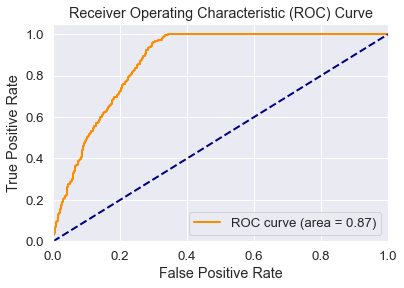

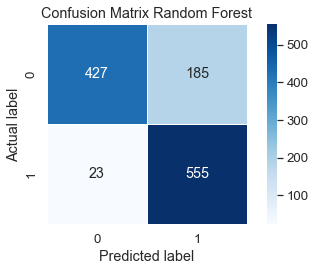

In [258]:

# Set the best parameters
best_params = {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

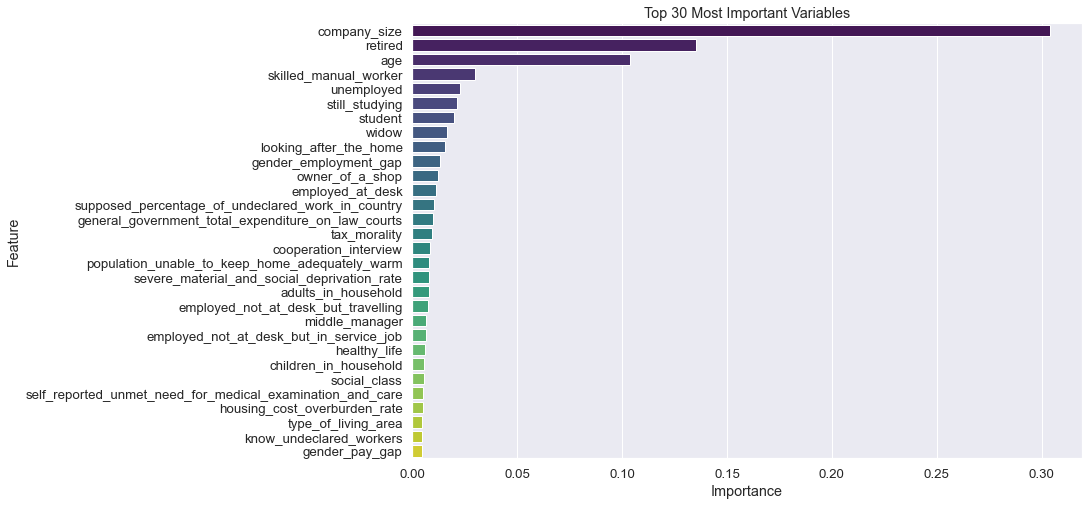

In [248]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 2. MLP Neural Network

In [249]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [250]:
def add_layers(layers_dict):
    # Initialization
    model = Sequential()

    # Add layers
    model.add(Input(shape=(126,))) # 126 = number of variables
    model.add(Dense(layers_dict['inic']['uni'], activation=layers_dict['inic']['activ']))
    for i in list(layers_dict.keys())[1:-2]:
        model.add(Dense(layers_dict[i]['uni'], activation=layers_dict[i]['activ']))      # hidden layer i
        if 'dropout' in layers_dict[i]:
            model.add(Dropout(rate=layers_dict[i]['dropout']))

    model.add(Dense(layers_dict['end']['uni'], activation=layers_dict['end']['activ']))  # exit layer

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    return model

In [251]:
def train_model(model, X_train, X_test, y_train, y_test, multiclass, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    if multiclass:
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        score = model.evaluate(X_test, y_test, verbose=1)
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        classification_rep = classification_report(y_test_classes, y_pred_classes)

        # Put results in dataframe
        results = pd.Series({'Layers': len(model.layers) - 2,  # Excluding input and output layers, and dropouts
                             'Epochs': epochs,
                             'Batch_Size': batch_size,
                             'Test_Loss': score[0],
                             'Test_Accuracy': score[1],
                             'conf_matrix': conf_matrix,
                             'classification_rep': classification_rep
                             })

    else:
        y_pred = (y_pred > 0.5)
        score = model.evaluate(X_test, y_test, verbose=1)
        # print("Test Loss and Accuracy:", score)

        # Predictions and evaluation
        # conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test,y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        # Put results in dataframe
        results = pd.Series({'Layers': len(model.layers) - 2,  # Excluding input and output layers, and dropouts
                                'Epochs': epochs,
                                'Batch_Size': batch_size,
                                'Test_Loss': score[0],
                                'Test_Accuracy': score[1],
                                'Precision': precision,
                                'Recall': recall,
                                'F1_Score': f1,
                                'Kappa_Score': kappa})

    return model, results

In [252]:
def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1, multiclass=False):
    uni_ocultas = []
    f_activ = []
    for i in list(layers_dict.keys())[1:-2]:
        uni_ocultas.append(layers_dict[i]['uni'])
        f_activ.append(layers_dict[i]['activ'])

    # compile model
    model = add_layers(layers_dict)

    # train + predict model
    model, results_df = train_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose, multiclass=multiclass)

    results_df['Uni_Ocultas'] = str(uni_ocultas)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    if multiclass:
        results_df = results_df[['Layers', 'Uni_Ocultas', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                  'classification_rep', 'conf_matrix']]
    else:
        results_df = results_df[['Layers', 'Uni_Ocultas', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]
    return model, results_df

In [254]:
df_all_results_relu = pd.DataFrame(columns=['Layers', 'Uni_Ocultas', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                        'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

In [ ]:
#RELU, 1 strat

start_time = time.time()

for l1 in [252, 126, 64, 32, 8,2]:
            layers_dict = {
                'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                'end' : {'uni': 1, 'activ': 'sigmoid'},
                'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
            }
            model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
            results_df = pd.DataFrame(results_df).T
            df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
            print()

end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
df_all_results_relu

df_all_results_relu.to_csv('undersample_models.csv', index=False)

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 816us/step - accuracy: 0.7403 - loss: 0.5192
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step - accuracy: 0.8459 - loss: 0.3481
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 792us/step - accuracy: 0.8507 - loss: 0.3222
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step - accuracy: 0.8715 - loss: 0.2951
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step - accuracy: 0.8738 - loss: 0.2802
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7923 - loss: 0.4056 

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 794us/step - accuracy: 0.7453 - loss: 0.5154
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 774us/step - accuracy: 0.8247 - loss: 0.3756
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 785us/step - accuracy: 0.8454 - loss: 0.3321
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 777us/step - accuracy: 0.8584 - loss: 0.3039
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 788us/step - accuracy: 0.8674 - loss: 0.

In [ ]:
# RELU, 2 straturi

start_time = time.time()
n = 0

for l1 in [252, 126, 64]:
    for l2 in [126, 64, 32, 8, 4, 2]:
        n = n + 1
        layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }
        print(n)
        model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
        results_df = pd.DataFrame(results_df).T

        df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
        print()

end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
df_all_results_relu

df_all_results_relu.to_csv('undersample_models.csv', index=False)

1
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 907us/step - accuracy: 0.7286 - loss: 0.5278
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 907us/step - accuracy: 0.8324 - loss: 0.3663
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 905us/step - accuracy: 0.8461 - loss: 0.3396
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 909us/step - accuracy: 0.8576 - loss: 0.3165
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 910us/step - accuracy: 0.8559 - loss: 0.3116
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.8091 - loss: 0.4375

2
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 881us/step - accuracy: 0.7251 - loss: 0.5367
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.8412 - loss: 0.3647
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.8434 - loss: 0.3474
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 880us/step - accuracy: 0.8604 - loss: 0.3282
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.8618 - loss

In [ ]:
#RELU, 3 straturi

start_time = time.time()
n=0

for l1 in [252]:
    for l2 in [126, 64, 32]:
        for l3 in [64, 32, 8, 2]:
            n = n + 1
            layers_dict = {
                'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                'end' : {'uni': 1, 'activ': 'sigmoid'},
                'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
            }
            print(n)
            model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
            results_df = pd.DataFrame(results_df).T
            df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
            print()


end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
df_all_results_relu

df_all_results_relu.to_csv('undersample_models.csv', index=False)

1
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7025 - loss: 0.5483
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8255 - loss: 0.3754
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8449 - loss: 0.3608
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8517 - loss: 0.3357
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8591 - loss: 0.3166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.8137 - loss: 0.4154

2
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6792 - loss: 0.5637
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8285 - loss: 0.3744
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8435 - loss: 0.3446
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8538 - loss: 0.3353
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8583 - loss: 0.3202
38/38 ━━━━━

In [ ]:
#RELU, 4 straturi

start_time = time.time()
n = 0

for l1 in [252]:
    for l2 in [126, 64, 32]:
        for l3 in [64, 32, 8]:
            for l4 in [ 32, 8, 4, 2]:
                n = n + 1
                layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                    'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                    'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                    'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
                }
                print(n)
                model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                print()


end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
df_all_results_relu

df_all_results_relu.to_csv('undersample_models.csv', index=False)

1
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7376 - loss: 0.5049
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8476 - loss: 0.3450
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8604 - loss: 0.3189
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8716 - loss: 0.2890
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8784 - loss: 0.2612
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.7955 - loss: 0.4514

2
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7472 - loss: 0.5068
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8428 - loss: 0.3526
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 999us/step - accuracy: 0.8576 - loss: 0.3241
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 995us/step - accuracy: 0.8641 - loss: 0.3000
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8809 - loss: 0.2784
38/38 ━

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 936us/step - accuracy: 0.8527 - loss: 0.3309
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 937us/step - accuracy: 0.8557 - loss: 0.3205
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 937us/step - accuracy: 0.8708 - loss: 0.2877
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.8021 - loss: 0.4204

22
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 927us/step - accuracy: 0.7228 - loss: 0.5241
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 939us/step - accuracy: 0.8393 - loss: 0.3451
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 936us/step - accuracy: 0.8441 - loss: 0.3399
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 931us/step - accuracy: 0.8677 - loss: 0.2927
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 932us/step - accuracy: 0.8735 - loss: 0.2789
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.8034 - loss: 0.4641

23
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step - accur

In [ ]:
#RELU, 5 straturi

start_time = time.time()
n = 0

for l1 in [252]:
    for l2 in [126, 64, 32]:
        for l3 in [64, 32, 8]:
            for l4 in [ 32, 8, 4]:
                for l5 in [ 8, 4, 2]:
                    n = n + 1
                    layers_dict = {
                        'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                        'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                        'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                        'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                        'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                        'l5' : {'uni': l5, 'activ': 'relu', 'dropout': 0.2},
                        'end' : {'uni': 1, 'activ': 'sigmoid'},
                        'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
                    }
                    print(n)
                    model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                    print()


end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
df_all_results_relu

df_all_results_relu.to_csv('undersample_models.csv', index=False)

1
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 975us/step - accuracy: 0.6848 - loss: 0.5445
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8373 - loss: 0.3629
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 973us/step - accuracy: 0.8510 - loss: 0.3290
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 971us/step - accuracy: 0.8686 - loss: 0.2974
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 972us/step - accuracy: 0.8797 - loss: 0.2716
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7928 - loss: 0.4444  

2
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 950us/step - accuracy: 0.7032 - loss: 0.6232
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 951us/step - accuracy: 0.8367 - loss: 0.4847
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 960us/step - accuracy: 0.8382 - loss: 0.4323
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 965us/step - accuracy: 0.8553 - loss: 0.3871
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 955us/step - accuracy: 0.8785 - loss: 

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8256 - loss: 0.3862
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7970 - loss: 0.4288

22
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7415 - loss: 0.5358
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8334 - loss: 0.3655
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8430 - loss: 0.3444
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8595 - loss: 0.3219
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8722 - loss: 0.3058
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8008 - loss: 0.4191  

23
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7091 - loss: 0.5374
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8263 - loss: 0.3712
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8455 - loss

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8260 - loss: 0.4005
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8259 - loss: 0.3869
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8320 - loss: 0.3801
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8334 - loss: 0.3749
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8087 - loss: 0.4090  

43
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7215 - loss: 0.5416
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8303 - loss: 0.3609
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8456 - loss: 0.3401
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8622 - loss: 0.3142
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8758 - loss: 0.2852
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8082 - loss: 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8075 - loss: 0.4175  

63
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6535 - loss: 0.6501
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8230 - loss: 0.5005
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8428 - loss: 0.4303
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8481 - loss: 0.3963
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8691 - loss: 0.3549
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.8147 - loss: 0.4913

64
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7172 - loss: 0.5235
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8358 - loss: 0.3589
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8492 - loss: 0.3301
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8

In [ ]:
df_all_results_relu.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Layers,Uni_Ocultas,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
13,4.0,"[126, 64]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.390749,0.82521,0.75766,0.941176,0.839506,0.652473
397,4.0,"[252, 126, 8, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.397449,0.82521,0.742782,0.979239,0.844776,0.653201
481,4.0,"[252, 4]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.401568,0.823529,0.756983,0.937716,0.837713,0.649098
192,5.0,"[252, 126, 64, 8, 8]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.398818,0.822689,0.744341,0.967128,0.841234,0.648015
493,4.0,"[64, 4]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.392078,0.822689,0.764791,0.916955,0.833989,0.647039
461,6.0,"[252, 126, 8]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.39687,0.821008,0.748299,0.951557,0.837776,0.644407
60,5.0,"[252, 64, 32, 32, 8]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.388079,0.821008,0.748977,0.949827,0.837529,0.644373
49,5.0,"[252, 126, 8, 4, 4]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.477364,0.821008,0.751032,0.944637,0.836782,0.644272
145,6.0,"[252, 64, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.393192,0.821008,0.741083,0.970588,0.840449,0.64478
205,5.0,"[252, 126, 32, 4, 4]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.397496,0.820168,0.740106,0.970588,0.83982,0.643129


### Optimizare - schimb de funcții de activare

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 854us/step - accuracy: 0.7607 - loss: 0.4928
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 849us/step - accuracy: 0.8070 - loss: 0.3922
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 855us/step - accuracy: 0.8199 - loss: 0.3861
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 857us/step - accuracy: 0.8290 - loss: 0.3628
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 849us/step - accuracy: 0.8333 - loss: 0.3576
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.8007 - loss: 0.4038
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Training Accuracy: 0.83
Test Accuracy: 0.82
Confusion Matrix:
[[407 205]
 [ 13 565]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       612
           1       0.73      0.98      0.84       578

    accuracy                           0.82      1190
   macro avg       0.85      0.82      0.81      1190
weighted avg       0

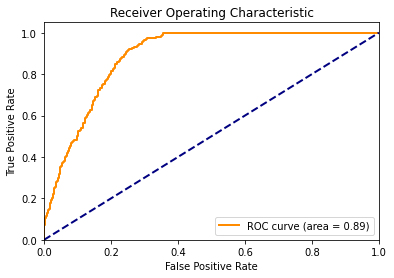

In [ ]:
#4.0	[126, 64]	['relu', 'relu']	binary_crossentropy	Adam

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 126, 'activ': 'tanh', 'dropout': 0.2},
            'l2' : {'uni': 64, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adam', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 854us/step - accuracy: 0.6914 - loss: 0.5722
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 845us/step - accuracy: 0.8095 - loss: 0.4143
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 849us/step - accuracy: 0.8070 - loss: 0.4249
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 846us/step - accuracy: 0.8134 - loss: 0.4042
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 842us/step - accuracy: 0.8112 - loss: 0.4074
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.8004 - loss: 0.4054

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
Training Accuracy: 0.82
Test Accuracy: 0.82
Confusion Matrix:
[[397 215]
 [  2 576]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.79       612
           1       0.73      1.00      0.84       578

    accuracy                           0.82      1190
   macro avg       0.86      0.82      0.81      1190
weighted avg       

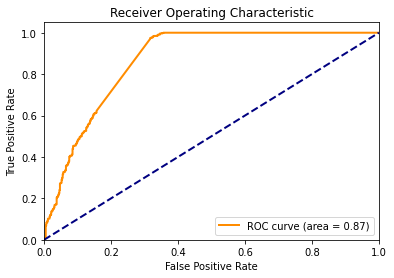

In [ ]:
#4.0	[252, 126, 8, 4]	['relu', 'relu', 'relu', 'relu']	binary_crossentropy	SGD

layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': 252, 'activ': 'tanh', 'dropout': 0.2},
                    'l2' : {'uni': 126, 'activ': 'relu', 'dropout': 0.2},
                    'l3' : {'uni': 8, 'activ': 'tanh', 'dropout': 0.2},
                    'l4' : {'uni': 4, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'SGD', 'metrics' : ['accuracy']}
                }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
print()

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 5s 875us/step - accuracy: 0.7123 - loss: 0.5428
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 869us/step - accuracy: 0.8054 - loss: 0.3983
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 870us/step - accuracy: 0.8185 - loss: 0.3716
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step - accuracy: 0.8176 - loss: 0.3654
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 870us/step - accuracy: 0.8250 - loss: 0.3488
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.8035 - loss: 0.4016
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
Training Accuracy: 0.85
Test Accuracy: 0.82
Confusion Matrix:
[[438 174]
 [ 37 541]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       612
           1       0.76      0.94      0.84       578

    accuracy                           0.82      1190
   macro avg       0.84      0.83      0.82      1190
weighted avg       0

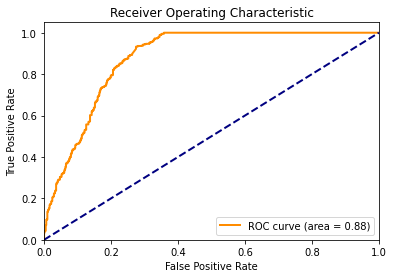

In [ ]:
#4.0	[252, 4]	['relu', 'relu']	binary_crossentropy	Adamax

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'tanh', 'input_s': (126,)},
            'l1' : {'uni': 252, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 4, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
df_all_results_relu.sort_values(by='Test_Accuracy', ascending=False)

,Layers,Uni_Ocultas,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
1,4.0,"[126, 64]","['tanh', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.391067,0.829412,0.764457,0.937716,0.842269,0.660681
3,4.0,"[126, 64]","['tanh', 'tanh']",binary_crossentropy,Adam,5.0,1.0,0.397608,0.828571,0.784195,0.892734,0.834951,0.658177
16,4.0,"[252, 4]","['tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.37714,0.826891,0.746032,0.975779,0.845577,0.656438
2,4.0,"[126, 64]","['tanh', 'tanh']",binary_crossentropy,Adam,5.0,1.0,0.375406,0.82605,0.763869,0.929066,0.838407,0.653896
13,4.0,"[252, 4]","['tanh', 'relu']",binary_crossentropy,Adamax,10.0,1.0,0.380709,0.82437,0.748318,0.961938,0.841787,0.651218
9,8.0,"[252, 126, 8, 4]","['relu', 'relu', 'tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.37035,0.823529,0.738342,0.986159,0.844444,0.650033
17,4.0,"[252, 4]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.388259,0.822689,0.756643,0.935986,0.836814,0.64741
6,8.0,"[252, 126, 8, 4]","['tanh', 'relu', 'relu', 'tanh']",binary_crossentropy,SGD,5.0,1.0,0.383402,0.822689,0.753103,0.944637,0.838066,0.647578
14,4.0,"[252, 4]","['tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.373006,0.819328,0.734194,0.984429,0.841094,0.641752
11,8.0,"[252, 126, 8, 4]","['tanh', 'relu', 'tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.386431,0.817647,0.728192,0.99654,0.84149,0.638695


In [ ]:
#df_all_results_relu.to_csv('undersample_models_tanh.csv', index=False)
df_all_results_relu.to_csv('undersample_models.csv', index=False)

## Model final MLP

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 881us/step - accuracy: 0.7633 - loss: 0.4817
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.8144 - loss: 0.3872
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step - accuracy: 0.8251 - loss: 0.3738
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.8243 - loss: 0.3612
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 4s 887us/step - accuracy: 0.8335 - loss: 0.3469
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.8132 - loss: 0.3889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training Accuracy: 0.83
Confusion Matrix:
[[409 203]
 [ 23 555]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       612
           1       0.73      0.96      0.83       578

    accuracy                           0.81      1190
   macro avg       0.84      0.81      0.81      1190
weighted avg       0.84      0.81      0.8

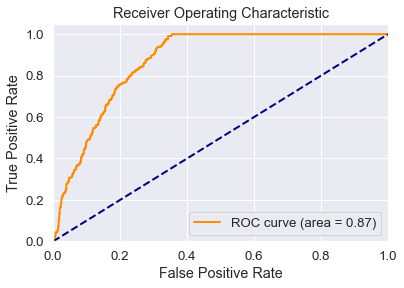

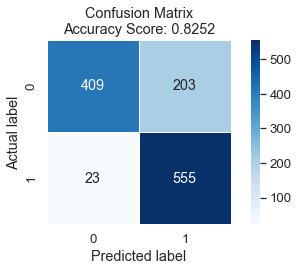

In [256]:
#4.0	[126, 64]	['relu', 'relu']	binary_crossentropy	Adam

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'tanh', 'input_s': (126,)},
            'l1' : {'uni': 126, 'activ': 'tanh', 'dropout': 0.2},
            'l2' : {'uni': 64, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adam', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob_MLP = model.predict(X_test)
y_pred_MLP = (y_pred_prob_MLP > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_MLP)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_MLP, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_MLP)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_pred_MLP)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix\nAccuracy Score: {test_accuracy:.4f}')

# Adjust layout
plt.tight_layout()
plt.show()


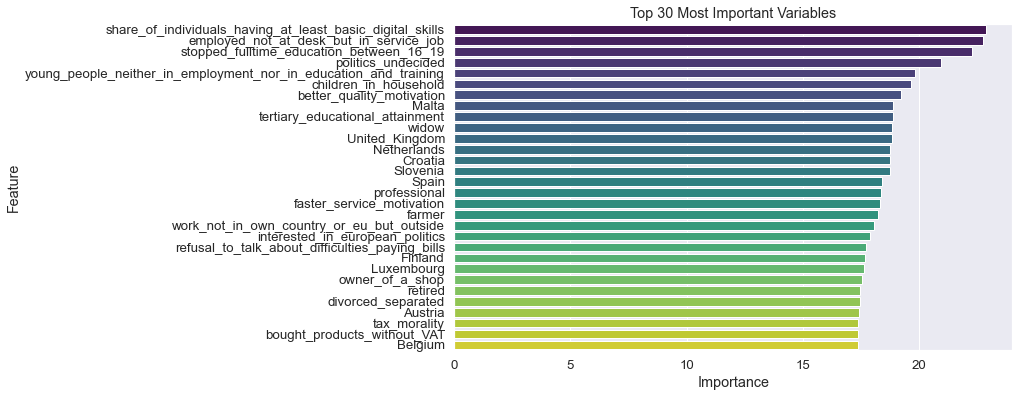

In [257]:
# Get the weights of the connections between the input layer and the first hidden layer
weights_layer1 = model.layers[1].get_weights()[0]  # Assuming 'l1' is the second layer in your model

# Calculate the absolute sum of weights for each input feature
feature_importance = np.abs(weights_layer1).sum(axis=1)

# Get the names of the input features from the DataFrame columns
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 3. Tab Net with CV

In [259]:
#SET SEED
np.random.seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Define TabNetClassifier model
tabnet_model = TabNetClassifier()

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')

# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train) 




C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.98798 |  0:00:00s
epoch 1  | loss: 0.77626 |  0:00:00s
epoch 2  | loss: 0.73591 |  0:00:01s
epoch 3  | loss: 0.68913 |  0:00:01s
epoch 4  | loss: 0.65454 |  0:00:01s
epoch 5  | loss: 0.63434 |  0:00:01s
epoch 6  | loss: 0.60403 |  0:00:02s
epoch 7  | loss: 0.57534 |  0:00:02s
epoch 8  | loss: 0.56764 |  0:00:02s
epoch 9  | loss: 0.53763 |  0:00:02s
epoch 10 | loss: 0.51672 |  0:00:03s
epoch 11 | loss: 0.49929 |  0:00:03s
epoch 12 | loss: 0.48504 |  0:00:03s
epoch 13 | loss: 0.47061 |  0:00:04s
epoch 14 | loss: 0.45877 |  0:00:04s
epoch 15 | loss: 0.4331  |  0:00:04s
epoch 16 | loss: 0.43158 |  0:00:04s
epoch 17 | loss: 0.4305  |  0:00:05s
epoch 18 | loss: 0.42502 |  0:00:05s
epoch 19 | loss: 0.42006 |  0:00:05s
epoch 20 | loss: 0.41937 |  0:00:05s
epoch 21 | loss: 0.40629 |  0:00:06s
epoch 22 | loss: 0.40415 |  0:00:06s
epoch 23 | loss: 0.40162 |  0:00:06s
epoch 24 | loss: 0.40256 |  0:00:07s
epoch 25 | loss: 0.40095 |  0:00:07s
epoch 26 | loss: 0.40343 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.94589 |  0:00:00s
epoch 1  | loss: 0.79762 |  0:00:00s
epoch 2  | loss: 0.74068 |  0:00:00s
epoch 3  | loss: 0.6947  |  0:00:01s
epoch 4  | loss: 0.66746 |  0:00:01s
epoch 5  | loss: 0.63522 |  0:00:01s
epoch 6  | loss: 0.60517 |  0:00:01s
epoch 7  | loss: 0.57616 |  0:00:02s
epoch 8  | loss: 0.56181 |  0:00:02s
epoch 9  | loss: 0.53801 |  0:00:02s
epoch 10 | loss: 0.51702 |  0:00:03s
epoch 11 | loss: 0.49685 |  0:00:03s
epoch 12 | loss: 0.47758 |  0:00:03s
epoch 13 | loss: 0.46429 |  0:00:03s
epoch 14 | loss: 0.45513 |  0:00:04s
epoch 15 | loss: 0.44839 |  0:00:04s
epoch 16 | loss: 0.43967 |  0:00:04s
epoch 17 | loss: 0.443   |  0:00:05s
epoch 18 | loss: 0.42696 |  0:00:05s
epoch 19 | loss: 0.4258  |  0:00:05s
epoch 20 | loss: 0.41945 |  0:00:05s
epoch 21 | loss: 0.42494 |  0:00:06s
epoch 22 | loss: 0.41531 |  0:00:06s
epoch 23 | loss: 0.41677 |  0:00:06s
epoch 24 | loss: 0.41919 |  0:00:06s
epoch 25 | loss: 0.40775 |  0:00:07s
epoch 26 | loss: 0.41402 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97627 |  0:00:00s
epoch 1  | loss: 0.77885 |  0:00:00s
epoch 2  | loss: 0.73324 |  0:00:00s
epoch 3  | loss: 0.68869 |  0:00:01s
epoch 4  | loss: 0.65262 |  0:00:01s
epoch 5  | loss: 0.62055 |  0:00:01s
epoch 6  | loss: 0.59489 |  0:00:02s
epoch 7  | loss: 0.56844 |  0:00:02s
epoch 8  | loss: 0.54904 |  0:00:02s
epoch 9  | loss: 0.53156 |  0:00:02s
epoch 10 | loss: 0.50574 |  0:00:03s
epoch 11 | loss: 0.48616 |  0:00:03s
epoch 12 | loss: 0.45872 |  0:00:03s
epoch 13 | loss: 0.4593  |  0:00:04s
epoch 14 | loss: 0.43997 |  0:00:04s
epoch 15 | loss: 0.43866 |  0:00:04s
epoch 16 | loss: 0.43491 |  0:00:04s
epoch 17 | loss: 0.42283 |  0:00:05s
epoch 18 | loss: 0.4295  |  0:00:05s
epoch 19 | loss: 0.43088 |  0:00:05s
epoch 20 | loss: 0.42363 |  0:00:06s
epoch 21 | loss: 0.42448 |  0:00:06s
epoch 22 | loss: 0.42172 |  0:00:06s
epoch 23 | loss: 0.42703 |  0:00:06s
epoch 24 | loss: 0.41767 |  0:00:07s
epoch 25 | loss: 0.4166  |  0:00:07s
epoch 26 | loss: 0.40591 |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.965   |  0:00:00s
epoch 1  | loss: 0.78602 |  0:00:00s
epoch 2  | loss: 0.73922 |  0:00:00s
epoch 3  | loss: 0.67755 |  0:00:01s
epoch 4  | loss: 0.65383 |  0:00:01s
epoch 5  | loss: 0.60722 |  0:00:01s
epoch 6  | loss: 0.57871 |  0:00:01s
epoch 7  | loss: 0.54163 |  0:00:02s
epoch 8  | loss: 0.50955 |  0:00:02s
epoch 9  | loss: 0.4894  |  0:00:02s
epoch 10 | loss: 0.47906 |  0:00:03s
epoch 11 | loss: 0.45585 |  0:00:03s
epoch 12 | loss: 0.45713 |  0:00:03s
epoch 13 | loss: 0.44412 |  0:00:03s
epoch 14 | loss: 0.42975 |  0:00:04s
epoch 15 | loss: 0.4234  |  0:00:04s
epoch 16 | loss: 0.40508 |  0:00:04s
epoch 17 | loss: 0.40405 |  0:00:04s
epoch 18 | loss: 0.40669 |  0:00:05s
epoch 19 | loss: 0.39481 |  0:00:05s
epoch 20 | loss: 0.40387 |  0:00:05s
epoch 21 | loss: 0.39504 |  0:00:06s
epoch 22 | loss: 0.40549 |  0:00:06s
epoch 23 | loss: 0.3931  |  0:00:06s
epoch 24 | loss: 0.39215 |  0:00:06s
epoch 25 | loss: 0.39453 |  0:00:07s
epoch 26 | loss: 0.3853  |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95116 |  0:00:00s
epoch 1  | loss: 0.79998 |  0:00:00s
epoch 2  | loss: 0.72677 |  0:00:00s
epoch 3  | loss: 0.69662 |  0:00:01s
epoch 4  | loss: 0.66964 |  0:00:01s
epoch 5  | loss: 0.64346 |  0:00:01s
epoch 6  | loss: 0.60756 |  0:00:01s
epoch 7  | loss: 0.58653 |  0:00:02s
epoch 8  | loss: 0.56686 |  0:00:02s
epoch 9  | loss: 0.5429  |  0:00:02s
epoch 10 | loss: 0.51554 |  0:00:02s
epoch 11 | loss: 0.49481 |  0:00:03s
epoch 12 | loss: 0.46905 |  0:00:03s
epoch 13 | loss: 0.45729 |  0:00:03s
epoch 14 | loss: 0.44613 |  0:00:04s
epoch 15 | loss: 0.43081 |  0:00:04s
epoch 16 | loss: 0.42216 |  0:00:04s
epoch 17 | loss: 0.4202  |  0:00:04s
epoch 18 | loss: 0.41369 |  0:00:05s
epoch 19 | loss: 0.4243  |  0:00:05s
epoch 20 | loss: 0.40489 |  0:00:05s
epoch 21 | loss: 0.40587 |  0:00:05s
epoch 22 | loss: 0.41157 |  0:00:06s
epoch 23 | loss: 0.39731 |  0:00:06s
epoch 24 | loss: 0.40328 |  0:00:06s
epoch 25 | loss: 0.4035  |  0:00:07s
epoch 26 | loss: 0.4019  |  0:00:07s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90908 |  0:00:00s
epoch 1  | loss: 0.75078 |  0:00:00s
epoch 2  | loss: 0.69286 |  0:00:01s
epoch 3  | loss: 0.65962 |  0:00:01s
epoch 4  | loss: 0.63321 |  0:00:01s
epoch 5  | loss: 0.60085 |  0:00:02s
epoch 6  | loss: 0.55811 |  0:00:02s
epoch 7  | loss: 0.52889 |  0:00:02s
epoch 8  | loss: 0.51218 |  0:00:03s
epoch 9  | loss: 0.50624 |  0:00:03s
epoch 10 | loss: 0.50068 |  0:00:04s
epoch 11 | loss: 0.48386 |  0:00:04s
epoch 12 | loss: 0.48125 |  0:00:04s
epoch 13 | loss: 0.4671  |  0:00:05s
epoch 14 | loss: 0.46866 |  0:00:05s
epoch 15 | loss: 0.45886 |  0:00:05s
epoch 16 | loss: 0.45928 |  0:00:06s
epoch 17 | loss: 0.44908 |  0:00:06s
epoch 18 | loss: 0.44532 |  0:00:06s
epoch 19 | loss: 0.4379  |  0:00:07s
epoch 20 | loss: 0.43176 |  0:00:07s
epoch 21 | loss: 0.42725 |  0:00:08s
epoch 22 | loss: 0.4301  |  0:00:08s
epoch 23 | loss: 0.42547 |  0:00:08s
epoch 24 | loss: 0.41527 |  0:00:09s
epoch 25 | loss: 0.4232  |  0:00:09s
epoch 26 | loss: 0.4245  |  0:00:09s
e

Training Accuracy: 0.8734230445752733
Testing Accuracy: 0.7890756302521008

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       612
           1       0.74      0.88      0.80       578

    accuracy                           0.79      1190
   macro avg       0.80      0.79      0.79      1190
weighted avg       0.80      0.79      0.79      1190



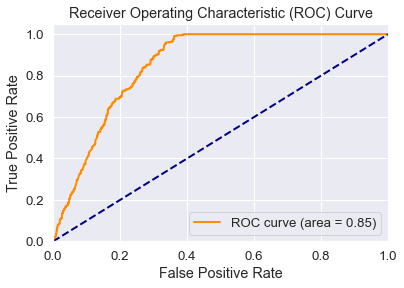

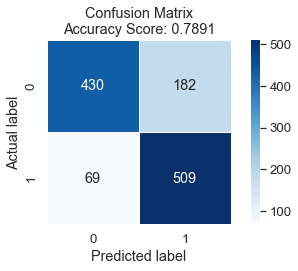

In [260]:
# Predict on training and testing data
y_train_pred = tabnet_model.predict(X_train_array)
y_test_pred_TABNET = tabnet_model.predict(X_test_array)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred_TABNET)

# Print train and test accuracy
print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

# Generate classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred_TABNET))

# Plot ROC curve
# Predict probabilities for the test set
y_prob_TABNET = tabnet_model.predict_proba(X_test_array)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob_TABNET)  
roc_auc_TABNET = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_TABNET)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_TABNET)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix\nAccuracy Score: {test_acc:.4f}')

# Adjust layout
plt.tight_layout()
plt.show()

Top 30 Feature Importances:
                                               Feature  Importance
37                                             retired    0.213791
71                                        company_size    0.210945
34                              looking_after_the_home    0.121390
35                                             student    0.113456
36                                          unemployed    0.062484
107         participation_in_early_childhood_education    0.025313
110                              gender_employment_gap    0.020973
23                                              Poland    0.019609
91                 sometimes_difficulties_paying_bills    0.018858
78                                        with_partner    0.016922
87                                 type_of_living_area    0.012436
96       people_at_risk_of_poverty_or_social_exclusion    0.012157
55                             know_undeclared_workers    0.011778
113                               

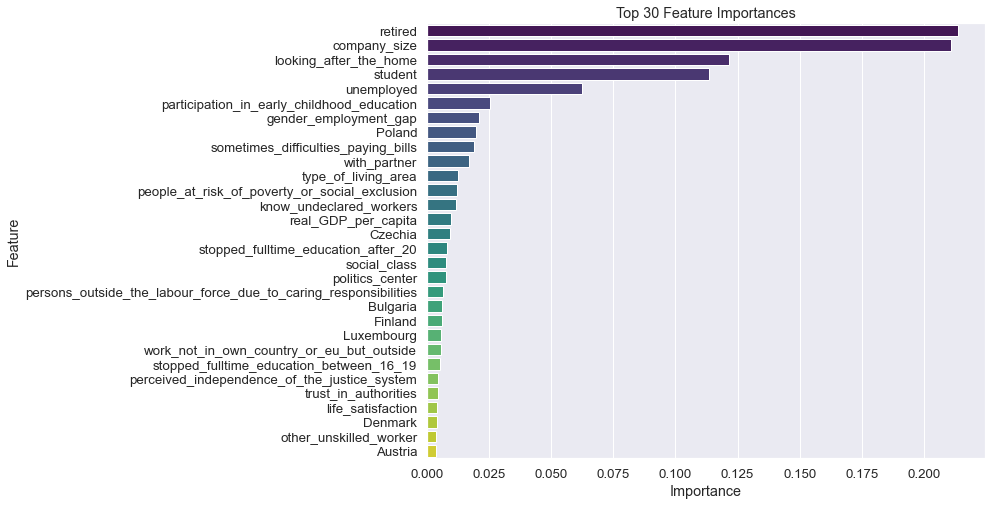

In [261]:

# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # If X_train is a DataFrame; if not, replace this with appropriate feature names
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 4. Convolutional Neural Networks

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
np.random.seed(140)
tf.random.set_seed(134)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (4756, 126)
Dimensions of X_test: (1190, 126)
Dimensions of y_train: (4756,)
Dimensions of y_test: (1190,)


In [5]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (4756, 14, 9, 1)
Dimensions of X_test_reshaped: (1190, 14, 9, 1)


In [107]:
#SET SEED
np.random.seed(140)
tf.random.set_seed(134)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),  # Define input shape using Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Assuming binary classification
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, shuffle=False)

# Extract training accuracy from history
training_accuracy = history.history['accuracy'][-1]
loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)

# Make predictions
predictions_proba = model.predict(X_test_reshaped)
predictions = (predictions_proba > 0.5).astype(int)

# Print accuracy
print()
print(f'Training Accuracy: {training_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5938 - loss: 0.6472 - val_accuracy: 0.7826 - val_loss: 0.4924
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7748 - loss: 0.4787 - val_accuracy: 0.8172 - val_loss: 0.4208
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7966 - loss: 0.4315 - val_accuracy: 0.8277 - val_loss: 0.3872
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8086 - loss: 0.4066 - val_accuracy: 0.8288 - val_loss: 0.3750
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8139 - loss: 0.3886 - val_accuracy: 0.8225 - val_loss: 0.3740
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8217 - loss: 0.3772 - val_accuracy: 0.8099 - val_loss: 0.3790
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8243 - loss: 0.3659 - val_accuracy: 0.8120 - val_loss: 0.3811
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.3543 - val_accuracy: 0.8183 - val_loss:

### ALWAYS CHANGING

In [7]:
#SET SEED
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),  # Define input shape using Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Assuming binary classification
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, shuffle=False)

# Extract training accuracy from history
training_accuracy = history.history['accuracy'][-1]
loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)

# Make predictions
predictions_proba = model.predict(X_test_reshaped)
predictions = (predictions_proba > 0.5).astype(int)

# Print accuracy
print()
print(f'Training Accuracy: {training_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6289 - loss: 0.6278 - val_accuracy: 0.7847 - val_loss: 0.4603
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - loss: 0.4295 - val_accuracy: 0.8141 - val_loss: 0.4064
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8187 - loss: 0.3915 - val_accuracy: 0.8246 - val_loss: 0.3909
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8236 - loss: 0.3739 - val_accuracy: 0.8277 - val_loss: 0.3932
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8274 - loss: 0.3661 - val_accuracy: 0.8246 - val_loss: 0.3910
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8304 - loss: 0.3580 - val_accuracy: 0.8277 - val_loss: 0.3883
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8332 - loss: 0.3462 - val_accuracy: 0.8309 - val_loss: 0.3822
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8342 - loss: 0.3378 - val_accuracy: 0.8277 - val_loss:

##  Functions to automatize experimenting-----------------------------------------

In [138]:
def add_layers(layers_dict):
    # Initialization
    model = Sequential()

    # Add input layer
    model.add(Input(shape=layers_dict['inic']['shape']))  

    # Add convolutional layers and pooling layers
    for i in range(1, len(layers_dict) - 2):  # Iterate over keys except 'inic' and 'end'
        conv_layer_info = layers_dict.get(f'conv{i}', None)
        pool_layer_info = layers_dict.get(f'pool{i}', None)
        
        if conv_layer_info:
            model.add(Conv2D(filters=conv_layer_info['filters'],
                             kernel_size=conv_layer_info['kernel_size'],
                             activation=conv_layer_info['activation'],
                             padding='same'))  # Use 'same' padding here
        if pool_layer_info:
            model.add(MaxPooling2D(pool_size=pool_layer_info['pool_size']))

    # Add flatten layer
    model.add(Flatten())

    # Add dense layers
    for i in range(1, len(layers_dict) - 2):
        dense_layer_info = layers_dict.get(f'dense{i}', None)
        if dense_layer_info:
            model.add(Dense(units=dense_layer_info['units'], activation=dense_layer_info['activation']))
            if 'dropout' in dense_layer_info:
                model.add(Dropout(rate=dense_layer_info['dropout']))

    # Add exit layer
    model.add(Dense(units=layers_dict['end']['units'], activation=layers_dict['end']['activation']))

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    
    return model

#--------------------------------------------------------------------------------------------------------
# Helper functions to count layers
def count_conv_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Conv2D))

def count_pooling_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, MaxPooling2D))

def count_flatten_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Flatten))

def count_dense_layers(model):
    # Exclude the output layer by iterating through all layers except the last one
    return sum(1 for layer in model.layers[:-1] if isinstance(layer, Dense))

#--------------------------------------------------------------------------------------------------------
def train_conv_model(model, X_train, X_test, y_train, y_test, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predictions and evaluation
    y_pred = model.predict(X_test)  
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test, verbose=1)
        
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Put results in dataframe
    results = pd.Series({'Convolutional': count_conv_layers(model),
                         'Pooling': count_pooling_layers(model),
                         'Flatten': count_flatten_layers(model),
                         'Dense': count_dense_layers(model),
                         'Epochs': epochs,
                         'Batch_Size': batch_size,
                         'Test_Loss': score[0],
                         'Test_Accuracy': score[1],
                         'Precision': precision,
                         'Recall': recall,
                         'F1_Score': f1,
                         'Kappa_Score': kappa})

    return model, results

#--------------------------------------------------------------------------------------------------------
def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1):
  
    hidden = []
    f_activ = []
    for key in list(layers_dict.keys())[1:-2]:
        layer = layers_dict[key]
        if layer['type'] == 'conv2d' or layer['type'] == 'dense':
            if 'filters' in layer:
                hidden.append(layer['filters'])
            elif 'units' in layer:
                hidden.append(layer['units'])
            if 'activation' in layer:
                f_activ.append(layer['activation'])
                

    model = add_layers(layers_dict)
    model, results_df = train_conv_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose)

    results_df['Hidden_units'] = str(hidden)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    
    results_df = results_df[['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                             'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]

    return model, results_df



In [139]:
#Form dataset to store models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])
              

In [137]:
#Example of how it works
layers_dict = {
    'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
    'conv1': {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
    'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
    'conv2': {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 2
    'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 2
    'flatten': {'type': 'flatten'},                                                           # Flatten layer
    'dense1': {'type': 'dense', 'units': 128, 'activation': 'relu'},                          # Dense layer 1
    'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
    'compile': {'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
}

model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
df_all_results_CONV

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7136 - loss: 0.5563
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8147 - loss: 0.4077
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8144 - loss: 0.3948
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8231 - loss: 0.3780
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8274 - loss: 0.3576
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8262 - loss: 0.3913  


,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
0,2.0,2.0,1.0,1.0,"[32, 64, 128]","['relu', 'relu', 'relu']",binary_crossentropy,adam,5.0,1.0,0.410088,0.809244,0.750357,0.910035,0.822518,0.620419


In [ ]:
# TO KEEP FOR RUNNING IT ALL TOGETHER LATER

#SET SEED
np.random.seed(140)
tf.random.set_seed(134)

#Make vector to store models
CNN_model_vector = []

#Form dataset to store results of models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]


    
# Loop through the list of optimizers and compile the model with each one
start_time = time.time()
for optimizer in optimizers:
    
    #RELU, 1 filtru, 1 strat-----------------------------------------------------------------------------------------------
   
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 1layer, " +  str(n) + "/16")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                CNN_model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)



    # RELU, 2 filtre, 1 strat-------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32]:
        for f2 in [64, 32, 16]:
            for d1 in [252, 126, 64, 32]:
                n = n + 1
                
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'conv2': {'type': 'conv2d', 'filters': f2, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 2filters, 1layer, " +  str(n) + "/36")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                CNN_model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)


     #RELU, 1 filtru, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
            for d2 in [ 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 2layers, " +  str(n) + "/32")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                CNN_model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)

    
     #RELU, 2 filtre, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32 ]:
        for f2 in [ 32, 16]:
            for d1 in [252, 126, 64]:
                for d2 in [ 64, 32]:
                    n = n + 1
                    layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
                    }

                    print(optimizer +  ": 2filters, 2layers, " +  str(n) + "/36")
                    model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    CNN_model_vector.append(model)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                    print()
                    
    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)

end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

## FIND BEST CONVOLUTIONAL MODELS

In [148]:
# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]

#Make vector to store models
model_vector = []

#Form dataset to store results of models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])
#SET SEED
np.random.seed(140)
tf.random.set_seed(134)      

In [149]:


# Loop through the list of optimizers and compile the model with each one
for optimizer in optimizers:
    
    #RELU, 1 filtru, 1 strat-----------------------------------------------------------------------------------------------
    start_time = time.time()
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 1layer, " +  str(n) + "/16")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    end_time = time.time()
    print("Elapsed time:", end_time - start_time, "seconds")
    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)



SGD: 1filter, 1layer, 1/16
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7181 - loss: 0.5362
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8121 - loss: 0.4033
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8229 - loss: 0.3771
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8266 - loss: 0.3612
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8364 - loss: 0.3477
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.3996

SGD: 1filter, 1layer, 2/16
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7086 - loss: 0.5417
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8105 - loss: 0.4026
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8214 - loss: 0.3807
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8283 - loss: 0.3660
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/st

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7238 - loss: 0.5592
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8099 - loss: 0.4100
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8167 - loss: 0.3957
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8294 - loss: 0.3726
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8375 - loss: 0.3517
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7989 - loss: 0.4296  

Adam: 1filter, 1layer, 6/16
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7236 - loss: 0.5409
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8128 - loss: 0.4094
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8187 - loss: 0.3905
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8233 - loss: 0.3715
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8328 - loss:

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7092 - loss: 0.5632
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8131 - loss: 0.4118
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8238 - loss: 0.3817
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8276 - loss: 0.3645
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8355 - loss: 0.3490
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8097 - loss: 0.3827  

Adamax: 1filter, 1layer, 10/16
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7000 - loss: 0.5688
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8096 - loss: 0.4141
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8189 - loss: 0.3874
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8246 - loss: 0.3727
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8273 - loss: 0

In [151]:
for optimizer in optimizers:
    
    # RELU, 2 filtre, 1 strat-------------------------------------------------------------------------------------------------
    start_time = time.time()
    n = 0
    for f1 in [128, 64, 32]:
        for f2 in [64, 32, 16]:
            for d1 in [252, 126, 64, 32]:
                n = n + 1
                
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'conv2': {'type': 'conv2d', 'filters': f2, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 2filters, 1layer, " +  str(n) + "/36")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    end_time = time.time()
    print("Elapsed time:", end_time - start_time, "seconds")
    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)


  



SGD: 2filters, 1layer, 4/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6867 - loss: 0.5733
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8087 - loss: 0.4074
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8211 - loss: 0.3837
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8326 - loss: 0.3684
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8305 - loss: 0.3580
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8104 - loss: 0.3804

SGD: 2filters, 1layer, 8/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6826 - loss: 0.5736
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8147 - loss: 0.4048
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8227 - loss: 0.3871
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8259 - loss: 0.3777
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - loss: 0.3969

Adamax: 2filters, 1layer, 12/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6837 - loss: 0.5819
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8051 - loss: 0.4131
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8121 - loss: 0.3865
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8227 - loss: 0.3711
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8303 - loss: 0.3578
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8026 - loss: 0.4011  

Adamax: 2filters, 1layer, 16/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7106 - loss: 0.5595
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8156 - loss: 0.4040
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8229 - loss: 0.3775
Epoch 4/5
47

In [153]:
for optimizer in optimizers:

     #RELU, 1 filtru, 2 straturi------------------------------------------------------------------------------------------------
    start_time = time.time()
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
            for d2 in [ 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 2layers, " +  str(n) + "/32")
                model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                model_vector.append(model)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    end_time = time.time()
    print("Elapsed time:", end_time - start_time, "seconds")
    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)


SGD: 1filter, 2layers, 1/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7173 - loss: 0.5338
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8194 - loss: 0.3955
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8224 - loss: 0.3764
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8312 - loss: 0.3634
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8333 - loss: 0.3530
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7663 - loss: 0.4606

SGD: 1filter, 2layers, 2/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7178 - loss: 0.5378
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8147 - loss: 0.3940
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8208 - loss: 0.3832
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8250 - loss: 0.3697
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7186 - loss: 0.5419
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8124 - loss: 0.4010
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8223 - loss: 0.3811
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8259 - loss: 0.3721
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8271 - loss: 0.3636
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8090 - loss: 0.3783  

SGD: 1filter, 2layers, 22/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7123 - loss: 0.5491
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8125 - loss: 0.4029
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8272 - loss: 0.3832
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8296 - loss: 0.3712
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8295 - loss: 0.3

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7304 - loss: 0.5346
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8000 - loss: 0.4197
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8158 - loss: 0.3957
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8189 - loss: 0.3849
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8285 - loss: 0.3608
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6921 - loss: 0.9978  

Adam: 1filter, 2layers, 10/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7279 - loss: 0.5456
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8055 - loss: 0.4153
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8169 - loss: 0.3847
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8226 - loss: 0.3787
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8275 - loss: 

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7340 - loss: 0.5330
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8061 - loss: 0.4063
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8173 - loss: 0.3889
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8233 - loss: 0.3732
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8299 - loss: 0.3635
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7618 - loss: 0.6962  

Adam: 1filter, 2layers, 30/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7095 - loss: 0.5485
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8080 - loss: 0.4131
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8081 - loss: 0.3972
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8192 - loss: 0.3786
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8286 - loss: 0.


Adamax: 1filter, 2layers, 7/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7304 - loss: 0.5432
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8155 - loss: 0.4055
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8237 - loss: 0.3840
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8290 - loss: 0.3722
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8321 - loss: 0.3623
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.4058  

Adamax: 1filter, 2layers, 8/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6973 - loss: 0.5587
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8119 - loss: 0.4041
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8212 - loss: 0.3836
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8246 - loss: 0.3730
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8059 - loss: 0.3932  

Adamax: 1filter, 2layers, 27/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7051 - loss: 0.5599
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8126 - loss: 0.4110
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8201 - loss: 0.3833
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8262 - loss: 0.3665
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8309 - loss: 0.3530
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.8152 - loss: 0.3908

Adamax: 1filter, 2layers, 28/32
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6866 - loss: 0.5718
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8112 - loss: 0.4119
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8217 - loss: 0.3842
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/s

In [154]:
for optimizer in optimizers:
    
     #RELU, 2 filtre, 2 straturi------------------------------------------------------------------------------------------------
    start_time = time.time()
    n = 0
    for f1 in [128, 64, 32 ]:
        for f2 in [ 32, 16]:
            for d1 in [252, 126, 64]:
                for d2 in [ 64, 32]:
                    n = n + 1
                    layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                    }

                    print(optimizer +  ": 2filters, 2layers, " +  str(n) + "/36")
                    model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    model_vector.append(model)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                    print()

    end_time = time.time()
    print("Elapsed time:", end_time - start_time, "seconds")
    df_all_results_CONV.to_csv('undersample_models_CONV.csv', index=False)


SGD: 1filter, 1layer, 1/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7055 - loss: 0.5455
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8117 - loss: 0.3994
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8246 - loss: 0.3806
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8268 - loss: 0.3658
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8338 - loss: 0.3531
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4088

SGD: 1filter, 1layer, 2/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7163 - loss: 0.5455
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8164 - loss: 0.3971
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8188 - loss: 0.3826
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8274 - loss: 0.3658
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/st

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7150 - loss: 0.5390
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8169 - loss: 0.3987
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8235 - loss: 0.3793
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8327 - loss: 0.3660
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8323 - loss: 0.3607
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8082 - loss: 0.3881  

SGD: 1filter, 1layer, 22/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7165 - loss: 0.5372
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8097 - loss: 0.4009
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8194 - loss: 0.3820
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8253 - loss: 0.3718
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8282 - loss: 0.35

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7275 - loss: 0.5253
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8064 - loss: 0.4151
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8142 - loss: 0.3932
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8162 - loss: 0.3873
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8192 - loss: 0.3775
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8146 - loss: 0.3799  

Adam: 1filter, 1layer, 6/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7127 - loss: 0.5471
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8095 - loss: 0.4046
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8142 - loss: 0.3852
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8223 - loss: 0.3789
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8314 - loss: 0.36

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7263 - loss: 0.5470
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8108 - loss: 0.4048
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8154 - loss: 0.3864
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8197 - loss: 0.3753
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8242 - loss: 0.3624
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.3806

Adam: 1filter, 1layer, 26/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7189 - loss: 0.5472
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8053 - loss: 0.4086
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8173 - loss: 0.3982
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8216 - loss: 0.3790
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8241 - loss: 0.369

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7201 - loss: 0.5568
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8200 - loss: 0.4006
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8246 - loss: 0.3802
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8290 - loss: 0.3665
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8378 - loss: 0.3527
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8302 - loss: 0.3767

Adamax: 1filter, 1layer, 10/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7140 - loss: 0.5530
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8142 - loss: 0.4012
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8238 - loss: 0.3815
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8330 - loss: 0.3686
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8333 -

4756/4756 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7136 - loss: 0.5641
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8145 - loss: 0.4041
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8224 - loss: 0.3854
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8284 - loss: 0.3724
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8304 - loss: 0.3628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4907

Adamax: 1filter, 1layer, 20/36
Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7157 - loss: 0.5569
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8157 - loss: 0.4027
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8252 - loss: 0.3817
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8310 - loss: 0.3682
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8332 -

In [156]:
x = pd.read_csv('undersample_models_CONV.csv')
x.sort_values(by='Test_Accuracy', ascending=False)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
114,1.0,1.0,1.0,2.0,"[128, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.379169,0.826050,0.745695,0.974048,0.844711,0.654753
49,2.0,2.0,1.0,1.0,"[128, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.378886,0.826050,0.744401,0.977509,0.845176,0.654819
90,1.0,1.0,1.0,2.0,"[64, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.382799,0.824370,0.755895,0.942907,0.839107,0.650852
221,1.0,1.0,1.0,2.0,"[64, 126, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.378128,0.823529,0.741470,0.977509,0.843284,0.649867
133,1.0,1.0,1.0,2.0,"[16, 126, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.393442,0.822689,0.743046,0.970588,0.841710,0.648082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1.0,1.0,1.0,2.0,"[128, 252, 64]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.533036,0.742857,0.749084,0.707612,0.727758,0.484501
30,1.0,1.0,1.0,1.0,"[16, 64]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.527284,0.742017,0.762089,0.681661,0.719635,0.482094
189,1.0,1.0,1.0,2.0,"[64, 252, 64]","['relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.539117,0.741176,0.773279,0.660900,0.712687,0.479830
115,1.0,1.0,1.0,2.0,"[64, 252, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.970644,0.688235,0.740139,0.551903,0.632309,0.371521


## Experiment changing Relu to Tanh

In [184]:
#Form dataset to store results of models
df_all_results_CONV_tanh = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])


In [220]:
#1.0 	1.0 	1.0 	2.0 	[128, 32, 32]	['relu', 'relu', 'relu']	binary_crossentropy 	Adam
layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 128, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 32, 'activation': 'tanh'},                          # Dense layer 1
                'dense2': {'type': 'dense', 'units': 32, 'activation': 'relu'},
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print()


Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7322 - loss: 0.5206
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8132 - loss: 0.3964
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8118 - loss: 0.3907
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8205 - loss: 0.3788
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8191 - loss: 0.3807
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8021 - loss: 0.3977



In [201]:
#2.0	2.0 	1.0 	1.0 	[128, 32, 32]	['relu', 'relu', 'relu']	binary_crossentropy 	SGD
layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'conv2': {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 32, 'activation': 'relu'},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'SGD' , 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7009 - loss: 0.5570
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8096 - loss: 0.4031
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8281 - loss: 0.3779
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8333 - loss: 0.3594
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8372 - loss: 0.3461
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8191 - loss: 0.3807


In [208]:
#1.0	1.0 	1.0 	2.0 	[64, 32, 32]	['relu', 'relu', 'relu']	binary_crossentropy 	SGD
layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 32, 'activation': 'tanh'},                          # Dense layer 1
                'dense2': {'type': 'dense', 'units': 32, 'activation': 'relu'},
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'SGD', 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print()

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7131 - loss: 0.5349
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8139 - loss: 0.3972
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8166 - loss: 0.3807
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8247 - loss: 0.3689
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8282 - loss: 0.3641
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.3901



In [210]:
df_all_results_CONV_tanh.to_csv('df_results_CONV_tanh.csv', index=False)

In [211]:
y = pd.read_csv('df_results_CONV_tanh.csv')
y.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
2,1.0,1.0,1.0,2.0,"[128, 32, 32]","['tanh', 'tanh', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.379803,0.826891,0.758333,0.944637,0.841294,0.655847
4,1.0,1.0,1.0,2.0,"[128, 32, 32]","['relu', 'tanh', 'tanh']",binary_crossentropy,Adam,5.0,1.0,0.382137,0.825210,0.737789,0.993080,0.846608,0.653465
1,1.0,1.0,1.0,2.0,"[128, 32, 32]","['tanh', 'tanh', 'tanh']",binary_crossentropy,Adam,5.0,1.0,0.393219,0.814286,0.744856,0.939446,0.830910,0.630946
11,2.0,2.0,1.0,1.0,"[128, 32, 32]","['relu', 'tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.393621,0.813445,0.764881,0.889273,0.822400,0.628265
3,1.0,1.0,1.0,2.0,"[128, 32, 32]","['relu', 'tanh', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.393380,0.810084,0.732190,0.960208,0.830838,0.623118
0,1.0,1.0,1.0,2.0,"[128, 32, 32]","['tanh', 'relu', 'tanh']",binary_crossentropy,Adam,5.0,1.0,0.405501,0.808403,0.739071,0.935986,0.825954,0.619311
6,2.0,2.0,1.0,1.0,"[128, 32, 32]","['tanh', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.406942,0.807563,0.760837,0.880623,0.816359,0.616489
7,2.0,2.0,1.0,1.0,"[128, 32, 32]","['tanh', 'tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.420753,0.801681,0.765528,0.852941,0.806874,0.604292
12,1.0,1.0,1.0,2.0,"[64, 32, 32]","['tanh', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.397737,0.800000,0.751479,0.878893,0.810207,0.601550
17,1.0,1.0,1.0,2.0,"[64, 32, 32]","['relu', 'tanh', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.405437,0.794118,0.758942,0.844291,0.799345,0.589182


## MODEL CNN FINAL 

Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7096 - loss: 0.5424
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8006 - loss: 0.4189
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8071 - loss: 0.3952
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8120 - loss: 0.3847
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8143 - loss: 0.3785
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79       612
           1       0.74      0.95      0.83       578

    accuracy                           0.82      1190
   macro avg       0.84      0.82      0.81      1190
weighted avg       0.84      0.82      0.81      1190



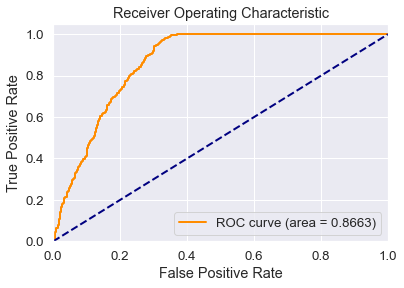

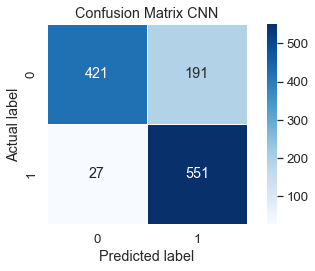

In [235]:
#1.0	1.0 	1.0 	2.0 	[128, 32, 32]	['tanh', 'tanh', 'relu']	binary_crossentropy 	Adam

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(140)
tf.random.set_seed(134)

# Define and compile the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1,  shuffle=False)

# Make predictions
predictions_proba_CNN = model.predict(X_test_reshaped)
predictions_CNN = (predictions_proba_CNN > 0.5).astype(int)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_CNN))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, predictions_CNN)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix CNN')

# Adjust layout
plt.tight_layout()
plt.show()




Epoch 1/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7111 - loss: 0.5445
Epoch 2/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7987 - loss: 0.4166
Epoch 3/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8104 - loss: 0.3984
Epoch 4/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8162 - loss: 0.3872
Epoch 5/5
4756/4756 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8173 - loss: 0.3833


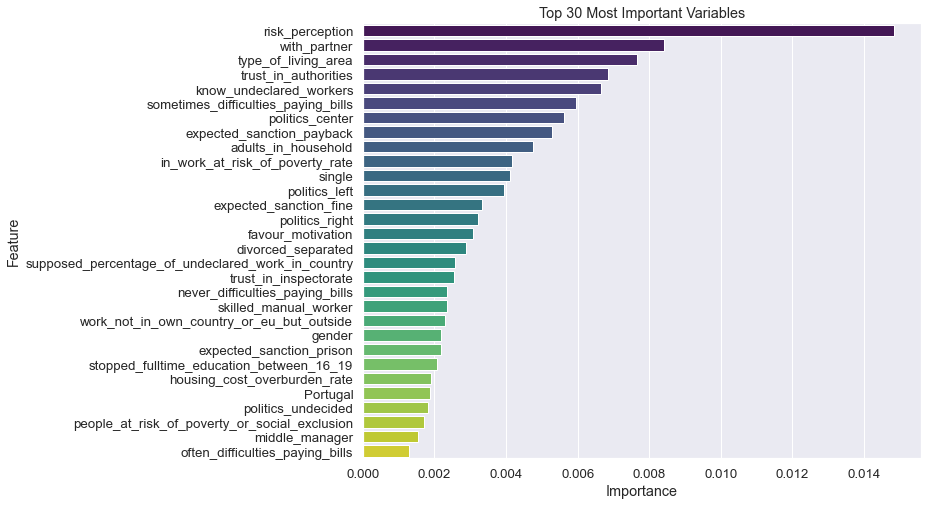

In [238]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set seeds for reproducibility
np.random.seed(140)
tf.random.set_seed(134)

# Define your CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False)

# Function to compute integrated gradients
@tf.function
def integrated_gradients(input_data):
    baseline = tf.zeros_like(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    grads = tape.gradient(predictions, input_data)
    integrated_grads = (input_data - baseline) * grads
    return tf.reduce_mean(integrated_grads, axis=0)

# Compute integrated gradients for each sample in the test set
ig_list = []
for sample in X_test_reshaped:
    ig = integrated_gradients(tf.convert_to_tensor([sample]))
    ig_list.append(ig.numpy())

# Calculate the mean importance across the test set
feature_importance = np.mean(ig_list, axis=0)

# Flatten feature_importance if it's not already 1D
feature_importance = feature_importance.flatten()

# Assuming X_train_reshaped was reshaped from a DataFrame X, with columns corresponding to the original feature names
input_feature_names = [f"Feature_{i}" for i in range(X_train_reshaped.shape[1] * X_train_reshaped.shape[2])]
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()


# ROC GRAPHICS

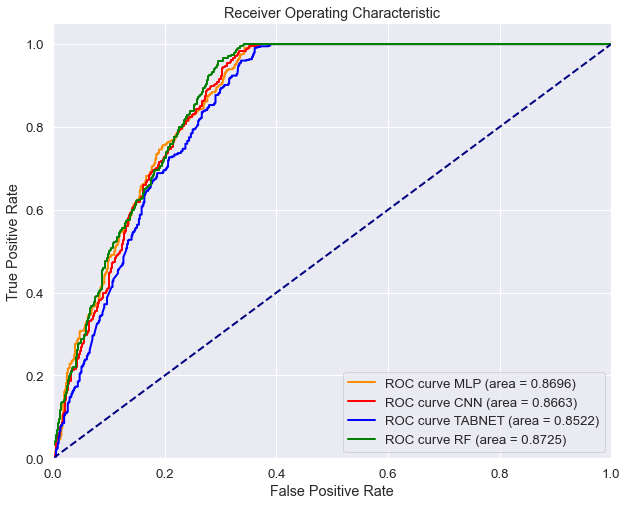

In [270]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))  # Adjust the size of the plot

# MLP
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob_MLP)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve MLP (area = {roc_auc1:.4f})')

# CNN
fpr4, tpr4, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, color='red', lw=2, label=f'ROC curve CNN (area = {roc_auc4:.4f})')

# TAB NET
fpr2, tpr2, _ = roc_curve(y_test, y_prob_TABNET)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve TABNET (area = {roc_auc2:.4f})')

# RF
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_RF)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'ROC curve RF (area = {roc_auc3:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')  # Move legend to lower right corner
plt.show()



## Heatmap Confusion Matrix

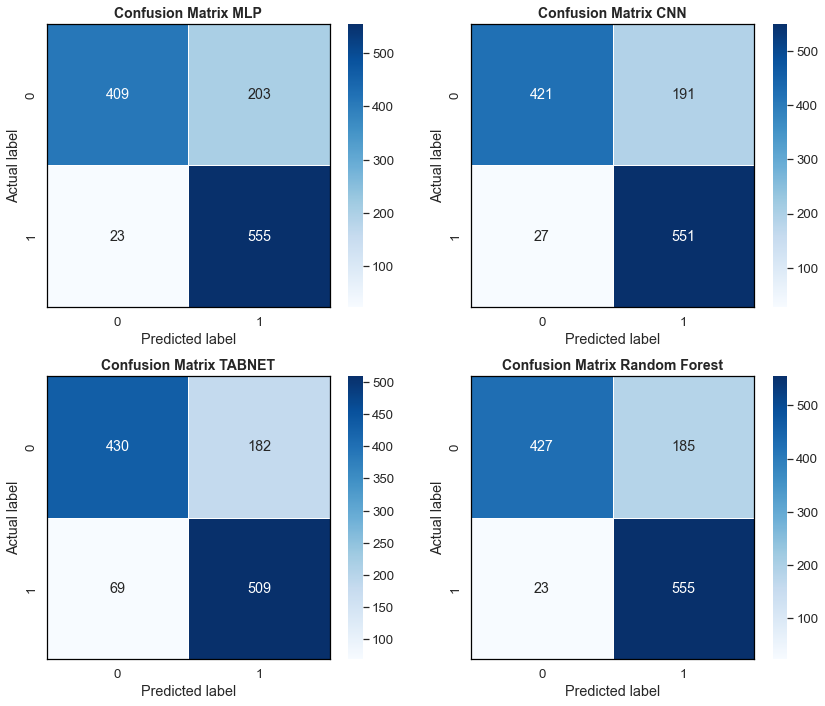

In [272]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Set common title properties
title_props = {'fontsize': 14, 'fontweight': 'bold'}

# Loop through each subplot and plot the confusion matrix
for i, ax in enumerate(axes.flat):
    if i == 0:
        cm = confusion_matrix(y_test, y_pred_MLP)
        title = 'Confusion Matrix MLP'
    elif i == 1:
        cm = confusion_matrix(y_test, predictions_CNN)
        title = 'Confusion Matrix CNN'
    elif i == 2:
        cm = confusion_matrix(y_test, y_test_pred_TABNET)
        title = 'Confusion Matrix TABNET'
    else:
        cm = confusion_matrix(y_test, y_pred_RF)
        title = 'Confusion Matrix Random Forest'
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=1, square=True, cmap='Blues', ax=ax)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title, **title_props)
    
    # Draw borders around each heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

# Adjust layout
plt.tight_layout()
plt.show()
